In [1]:
from tensorflow import keras
from pathlib import Path
import argparse
import yaml
import pandas as pd
import numpy as np

from utils.misc import triplet_to_str
from preprocessing.database import clean_database, download_database
from preprocessing.sets import preprocess_data

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--config', help='Path to the config file', default='./default_config.yml')
parser.add_argument('--log-dir', help='Path to the log directory', default='../log/')
parser.add_argument('--posters', help='Path to the posters', default='../data/posters/')
parser.add_argument('--models-dir', help='Path to the saved models', default='../data/models/')
parser.add_argument('--sets-dir', help='Path to the training and testing sets', default='../data/sets/')
parser.add_argument('--database', help='Path to the databse csv', default='../data/poster_data.csv')
parser.add_argument('--csv', help='Path to the clean csv', default='../data/')
parser.add_argument('-s', '--save', help='Save model', action='store_true')
parser.add_argument('-v', '--verbose', help='Verbose', action='store_true')

str_args = '-v -s'.split()
args, _ = parser.parse_known_args(str_args)

logger = None

In [3]:
config = yaml.safe_load(open(args.config, encoding='utf-8'))

nb_genres = len(config["genres"])
input_size = config["image_size"]

In [4]:
appendix_split = 's{}t{}_'.format(
    config['size_per_genre'],
    config['testing_split']
) + triplet_to_str(config['image_size']) + '_' + str(nb_genres) + ".npy"

data_name = [Path(prefix+appendix_split) for prefix in
    [args.sets_dir + 'xtr_',
    args.sets_dir + 'ytr_',
    args.sets_dir + 'idtr_',
    args.sets_dir + 'xtest_',
    args.sets_dir + 'ytest_',
    args.sets_dir + 'idtest_']
]

In [5]:
data_name[0]

PosixPath('../data/sets/xtr_s700t0.15_100-100-3_7.npy')

In [6]:
selection_name = args.csv+'clean_poster_data_'+str(nb_genres)+'.csv'

if Path(selection_name).exists():
    if args.verbose:
        print('Database already cleaned')
    clean_movies = pd.read_csv(Path(selection_name))
else:
    clean_movies = clean_database(Path(args.database))
    if args.save:
        clean_movies.to_csv(Path(selection_name))

Database already cleaned


In [7]:
if data_name[0].exists() and data_name[1].exists() and data_name[2].exists() and data_name[3].exists() and data_name[4].exists() and data_name[5].exists():
    if args.verbose:
        print('Training and testing sets alreadey made')
    train_posters, train_genres, train_ids = np.load(data_name[0]), np.load(data_name[1]), np.load(data_name[2])
    test_posters, test_genres, test_ids = np.load(data_name[3]), np.load(data_name[4]), np.load(data_name[5])

else:
    train_posters, train_genres, train_ids, test_posters, test_genres, test_ids = preprocess_data(
        clean_movies, config['genres'], config['size_per_genre'], args.posters, config['image_size'],
        config['seed'], testing_split=config['testing_split'], verbose=args.verbose, logger=logger
    )
    if args.save:
        sets_path = Path(args.sets_dir)
        if not sets_path.exists():
            sets_path.mkdir()
        np.save(data_name[0], train_posters)
        np.save(data_name[1], train_genres)
        np.save(data_name[2], train_ids)
        np.save(data_name[3], test_posters)
        np.save(data_name[4], test_genres)
        np.save(data_name[5], test_ids)

Training and testing sets alreadey made


In [8]:
resnet = keras.applications.resnet_v2.ResNet50V2(
    input_shape=input_size, include_top=False, weights="imagenet"
)

In [9]:
train_features = resnet.predict(train_posters.astype(np.float32)).reshape(
    (len(train_posters), -1)
)
    
test_features = resnet.predict(test_posters.astype(np.float32)).reshape(
    (len(test_posters), -1)
)

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(train_posters.reshape(len(train_posters), -1))

pca_resnet = PCA(n_components=2)
pca_resnet.fit(train_features)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

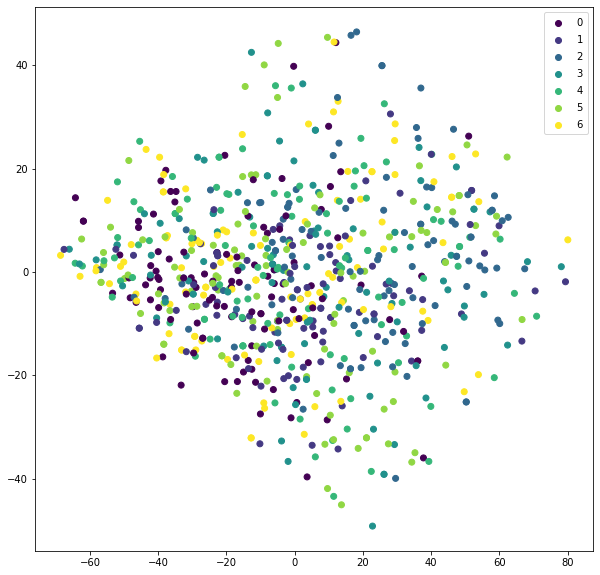

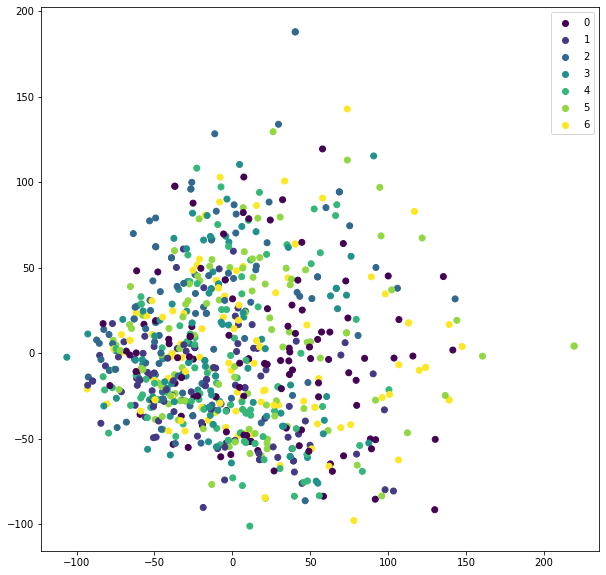

In [18]:
import matplotlib.pyplot as plt

indexes = np.random.choice(len(train_posters), 750)

def display2D(X_ortho, Y):
    colors = Y.argmax(axis=1)
    
    fig = plt.figure(figsize=(10, 10))
    
    scatter = plt.scatter(X_ortho[:, 0], X_ortho[:, 1], c=colors)
    
    plt.legend(*scatter.legend_elements())
    plt.show(fig)

display2D(
    pca.transform(train_posters.reshape(len(train_posters), -1))[indexes],
    train_genres[indexes]
)

display2D(
    pca_resnet.transform(train_features)[indexes],
    train_genres[indexes]
)

In [12]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=15)#, weights="distance")
knn.fit(train_features, train_genres)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                    weights='uniform')

In [13]:
predicted_genres = knn.predict(test_features)

In [14]:
genres_inv = {config['genres'][k]: k for k in config['genres'].keys()}

predictions = np.array([genres_inv[k] for k in np.argmax(predicted_genres, axis=1)])
ground_truth = np.array([genres_inv[k] for k in np.argmax(test_genres, axis=1)])

genres = config["genres"]

results_per_genre = {
    genre_true : {genre_pred : 0 for genre_pred in genres}
    for genre_true in genres
}

total_per_genre = {
    genre : 0
    for genre in genres
}

n = len(predictions)
for i in range(n):
    results_per_genre[ground_truth[i]][predictions[i]] += 1
    total_per_genre[ground_truth[i]] += 1

for genre_true in genres:
    print(
        genre_true + " (" + str(total_per_genre[genre_true] / n) + "):"
    )
    for genre_pred in genres:
        print(
            "    " + genre_pred + ": " + str(
                results_per_genre[genre_true][genre_pred] / total_per_genre[genre_true]
            )
        )
    print()

Action (0.14285714285714285):
    Action: 0.1619047619047619
    Animation: 0.21904761904761905
    Comédie: 0.12380952380952381
    Comédie dramatique: 0.11428571428571428
    Documentaire: 0.1619047619047619
    Drame: 0.08571428571428572
    Thriller-Policier: 0.13333333333333333

Animation (0.14285714285714285):
    Action: 0.11428571428571428
    Animation: 0.5619047619047619
    Comédie: 0.09523809523809523
    Comédie dramatique: 0.05714285714285714
    Documentaire: 0.13333333333333333
    Drame: 0.02857142857142857
    Thriller-Policier: 0.009523809523809525

Comédie (0.14285714285714285):
    Action: 0.0380952380952381
    Animation: 0.2857142857142857
    Comédie: 0.3238095238095238
    Comédie dramatique: 0.08571428571428572
    Documentaire: 0.12380952380952381
    Drame: 0.08571428571428572
    Thriller-Policier: 0.05714285714285714

Comédie dramatique (0.14285714285714285):
    Action: 0.05714285714285714
    Animation: 0.22857142857142856
    Comédie: 0.2095238095238095

In [15]:
accuracy = 0

for genre in genres:
    accuracy += results_per_genre[genre][genre]

accuracy /= len(test_posters)
print(accuracy)

0.2761904761904762
